## 이미지 분류 (EfficientNet) 실습 & GradCAM & AA

### Covid19 판독기

- [ref](https://keep-steady.tistory.com/35?category=702928)
- [colab url](https://bit.ly/3U0PY1q)

- Covid19 데이터
    - 정상: 300, [ref](https://www.kaggle.com/nih-chest-xrays/sample)
    - 비정상(코로나): 196, [ref](https://github.com/ieee8023/covid-chestxray-dataset.git)
    
- President 데이터
    - 이재명/윤석렬/심상정/안철수/이낙연/홍준표/이준석
    - 각 200장씩


221102, check

# Prepare

In [1]:
## down the EfficientNet&Adversarial code&data
!git clone https://github.com/airobotlab/lecture_1_advanced_cnn.git

!mv lecture_1_advanced_cnn/efficientnet_pytorch efficientnet_pytorch
!mv lecture_1_advanced_cnn/adversarial_attacks_pytorch adversarial_attacks_pytorch

!unzip lecture_1_advanced_cnn/data_covid19.zip  # covid data
# !unzip lecture_1_advanced_cnn/data_president.zip  # president data
!rm -rf lecture_1_advanced_cnn

Cloning into 'lecture_1_advanced_cnn'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 215 (delta 19), reused 0 (delta 0), pack-reused 168
Receiving objects: 100% (215/215), 158.59 MiB | 36.77 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Archive:  lecture_1_advanced_cnn/data_covid19.zip
   creating: data_covid19/
   creating: data_covid19/normal/
 extracting: data_covid19/normal/00001586_000.png  
 extracting: data_covid19/normal/00002927_003.png  
 extracting: data_covid19/normal/00000390_000.png  
 extracting: data_covid19/normal/00002633_005.png  
 extracting: data_covid19/normal/00001950_001.png  
 extracting: data_covid19/normal/00003079_000.png  
 extracting: data_covid19/normal/00003640_001.png  
 extracting: data_covid19/normal/00003741_002.png  
 extracting: data_covid19/normal/00003205_002.png  
 extracting: data_covid19/normal/00002469_000.png  
 extracting: data_covi

In [2]:
## load ibrary
import numpy as np
import json
import pprint
from PIL import Image
import PIL.Image as pilimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.metrics import f1_score
from tqdm import tqdm

In [3]:
## parameter
is_Test = False
# is_Test = True
num_epochs = 30
batch_size  = 128
gpu_idx = '0'
 
dataset = 'covid'
# dataset = 'president'

if dataset == 'president':
    data_path = 'data_president/data_president_small'  # 데이터 경로, 이 안엔 CLASS가 폴더별로 정리
    label_path = 'data_president/president_label.json'
    
    with open(label_path) as json_file:
        class_names = json.load(json_file)
        pprint.pprint(class_names)
        
    bbox=True  # bbox 그린다

        
elif dataset == 'covid':
    data_path = 'data_covid19'  # 데이터 경로, 이 안엔 CLASS가 폴더별로 정리
    label_path = 'data_covid19/president_label.json'
    
    class_names={
        '0': 'anomal',
        '1': 'normal'        
    }
    bbox=False  # 얼굴이 아니므로 bbox 안그린다    
    
save_path='output_%s'%(dataset)
num_classes = len(class_names)
print('num class : %d'%(num_classes))

num class : 2


In [4]:
## prepare data
# make dataset
from torchvision import transforms, datasets
from torch.utils.data import Subset, dataloader


transform_function = transforms.Compose([transforms.Resize((224, 224)),  # 모델 입력사이즈로 resize
                                         transforms.ToTensor(),  # [0, 255] -> [0, 1]
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
# class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
dataset = datasets.ImageFolder(data_path,
                               transform_function)

# make 8:1:1 idx & dataset
random_seed = 220413
random.seed(random_seed)
torch.manual_seed(random_seed)
random_idx = list(range(0, len(dataset)))
random.shuffle(random_idx)
print('data class: %s'%(dataset.classes))
print('total data num : %d'%len(random_idx))
print('random check : %s'%random_idx[:5])

proportion = [8, 1, 1]  ## !! 이 부분을 6, 2, 2로 바꾸면 train/valid/test 비율 조정 가능
proportion_data = [tmp*int(len(random_idx)/10) for tmp in proportion]
# assert sum(proportion_data) == len(random_idx)  # 반올림해서 총합은 틀려진다

train_idx = random_idx[:proportion_data[0]]
valid_idx = random_idx[proportion_data[0] : proportion_data[0]+proportion_data[1]]
test_idx  = random_idx[proportion_data[0]+proportion_data[1] :]

print('data proportion(train:valid:test) = %s : %s : %s'%(len(train_idx), len(valid_idx), len(test_idx)))

datasets = {}
datasets['train'] = Subset(dataset, train_idx)
datasets['valid'] = Subset(dataset, valid_idx)
datasets['test']  = Subset(dataset, test_idx)


data class: ['anomal', 'normal']
total data num : 496
random check : [266, 481, 241, 407, 218]
data proportion(train:valid:test) = 392 : 49 : 55


In [5]:
## prepare data
# make dataset
from torchvision import transforms, datasets
from torch.utils.data import Subset, dataloader


transform_function = transforms.Compose([transforms.Resize((224, 224)),  # 모델 입력사이즈로 resize
                                         transforms.ToTensor(),  # [0, 255] -> [0, 1]
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
# class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
dataset = datasets.ImageFolder(data_path, transform_function)

# make 8:1:1 idx & dataset
random_seed = 220413
random.seed(random_seed)
torch.manual_seed(random_seed)
random_idx = list(range(0, len(dataset)))
random.shuffle(random_idx)
print('data class: %s'%(dataset.classes))
print('total data num : %d'%len(random_idx))
print('random check : %s'%random_idx[:5])

proportion = [8, 1, 1]  ## !! 이 부분을 6, 2, 2로 바꾸면 train/valid/test 비율 조정 가능
proportion_data = [tmp*int(len(random_idx)/10) for tmp in proportion]
# assert sum(proportion_data) == len(random_idx)  # 반올림해서 총합은 틀려진다

train_idx = random_idx[:proportion_data[0]]
valid_idx = random_idx[proportion_data[0] : proportion_data[0]+proportion_data[1]]
test_idx  = random_idx[proportion_data[0]+proportion_data[1] :]

print('data proportion(train:valid:test) = %s : %s : %s'%(len(train_idx), len(valid_idx), len(test_idx)))

datasets = {}
datasets['train'] = Subset(dataset, train_idx)
datasets['valid'] = Subset(dataset, valid_idx)
datasets['test']  = Subset(dataset, test_idx)


data class: ['anomal', 'normal']
total data num : 496
random check : [266, 481, 241, 407, 218]
data proportion(train:valid:test) = 392 : 49 : 55


In [6]:
## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  number of batch(tvt) : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  number of batch(tvt) : 4 / 1 / 1


# For training

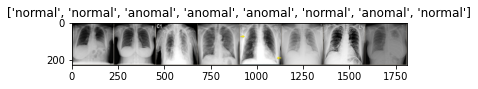

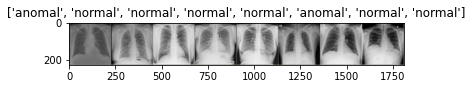

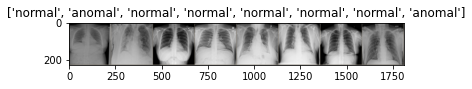

In [7]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 8

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

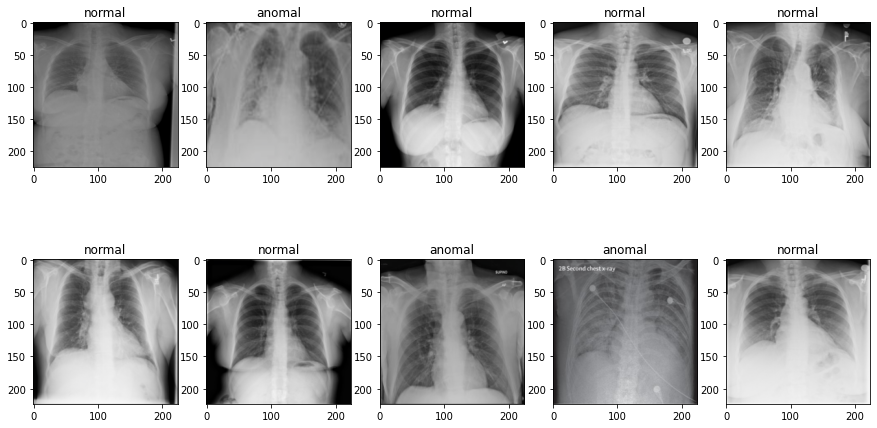

In [8]:
## batch의 tensor 이미지를 확인하기 위한 함수
def check_image_from_tensor(check_image, check_class):
    title = list(check_class.cpu().numpy())  # torch tensor to list
    
    # 5x1 형식으로 만들기 위해
    num_image = len(title)
    if num_image <= 5:
        columns = num_image
        rows = 1
    else:
        columns = 5
        rows = int(np.ceil(num_image/columns))

    fig=plt.figure(figsize=(3*columns, 4*rows))

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for i in range(1, num_image +1):
        inp = check_image[i-1].numpy().transpose((1, 2, 0))
        inp = std * inp + mean  # 원본 이미지로 변환
        inp = np.clip(inp, 0, 1)
        
        fig.add_subplot(rows, columns, i)
        plt.title(class_names[str(title[i-1])])
        plt.imshow(inp)
    plt.show()


num_show_img = 10
# data check
inputs, classes = next(iter(dataloaders['test']))
check_image, check_class = inputs[:num_show_img], classes[:num_show_img]
check_image_from_tensor(check_image, check_class)

In [9]:
## load model
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5
num_classes = num_classes  # 장싱, 비정상
freeze_extractor = True  # FC layer만 학습하고 efficientNet extractor 부분은 freeze하여 학습시간 단축, 89860 vs 4097408
use_multi_gpu = False

image_size = EfficientNet.get_image_size(model_name)
print('model input shape : (%d x %d)'%(image_size, image_size))
print('model output class : %d'%(num_classes))
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)

# fc 제외하고 freeze
if freeze_extractor:
    print('extractor freeze')
    for n, p in model.named_parameters():
        if '_fc' not in n:
            p.requires_grad = False
            

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)            
print('학습 parameters 개수 : %d'%(count_parameters(model)))

device = torch.device('cuda:%s'%(gpu_idx) if torch.cuda.is_available() else 'cpu')

# multi gpu(2개 이상)를 사용하는 경우
if use_multi_gpu:
    num_gpu = torch.cuda.device_count()
    if (device.type=='cuda') and (num_gpu > 1):
        print('use multi gpu : %d' % (num_gpu))
        model = nn.DataParallel(model, device_ids=list(range(num_gpu)))
        
model = model.to(device)

model input shape : (224 x 224)
model output class : 2


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
extractor freeze
학습 parameters 개수 : 2562


In [10]:
# define optimizer, criterion
criterion = nn.CrossEntropyLoss()  # 분류이므로 cross entrophy 사용

# optimizer 선언, SGD, Adam으로도 해보자
# optimizer = optim.SGD(model.parameters(), 
#                          lr = 0.05,
#                          momentum=0.9,
#                          weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98739)  # LR 스케쥴러, 점점 줄어든다

In [11]:
# define trainer
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, is_test=False, save_path='output'):
    since = time.time()

    if not os.path.isdir(save_path):  os.makedirs(save_path)  # 저장 폴더 생성
    # for saving best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, best_f1 = 0.0, 0.0
    train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1 = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print('\nEpoch %d/%d' % (epoch, num_epochs-1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            pred_list, label_list = [], []  
            # Iterate over data
#             for idx, batch in tqdm(enumerate(dataloaders[phase])):
            for idx, batch in enumerate(dataloaders[phase]):                

                # for test
                if is_test:
                    if idx > 2: break

                inputs, labels = batch  # image, label
                inputs = inputs.to(device)  # [128, 3, 224, 224]
                labels = labels.to(device)  # [128], tensor([1, 1, 1, 0, 1, ..])

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # 이미지가 입력을 때 모델을 통과하여 예측확률을 구함
                    _, preds = torch.max(outputs, 1)  # 예측 확률 중 최대값의 index 구함
                    loss = criterion(outputs, labels)  # 예측값과 정답 차이 비교

                    # 학습시만 backpropagation, backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)

                pred_list  += preds.data.cpu().numpy().tolist()
                label_list += labels.data.cpu().numpy().tolist()

            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            epoch_f1   = float(f1_score(label_list, pred_list, average='macro')*100)  # micro

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_f1.append(epoch_f1)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
                valid_f1.append(epoch_f1)

            print('{} Loss: {:.2f} | Acc: {:.2f} | f1: {:.2f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

            # save best model, validation acc가 높을때 저장, deep copy the model
    #         if (phase == 'valid') and (epoch_acc > best_acc):
            if (phase == 'valid') and (epoch_f1 > best_f1):            
                best_idx = epoch
                best_acc = epoch_acc
                best_f1  = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
    #                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d | %.2f | %.2f'%(best_idx, best_acc, best_f1))

    time_elapsed = time.time() - since
    print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.2f | %.2f' %(best_idx, best_acc, best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # multi gpu면 weight key에 'module.'이 붙으므로 떼고 저장
    if use_multi_gpu:
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    weights_path = os.path.join(save_path, 'model_%d_%.2f_%.2f.pt'%(best_idx, best_acc, best_f1))
    torch.save(model_state_dict, weights_path)
    torch.save(model_state_dict, os.path.join(save_path, 'best_model.pt'))
    
    print('save model_%d_%.2f_%.2f.pt'%(best_idx, best_acc, best_f1))
    return model, best_idx, best_acc, train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1, weights_path

In [12]:
# train!!
model, best_idx, best_acc, train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1, weights_path = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs,
    is_test=is_Test, save_path=save_path)


Epoch 0/29
----------
train Loss: 0.68 | Acc: 57.40 | f1: 57.25
valid Loss: 0.64 | Acc: 63.27 | f1: 38.75
==> best model saved - 0 | 63.27 | 38.75

Epoch 1/29
----------
train Loss: 0.58 | Acc: 74.23 | f1: 68.69
valid Loss: 0.62 | Acc: 63.27 | f1: 38.75

Epoch 2/29
----------
train Loss: 0.54 | Acc: 73.47 | f1: 66.58
valid Loss: 0.62 | Acc: 63.27 | f1: 38.75

Epoch 3/29
----------
train Loss: 0.51 | Acc: 73.98 | f1: 67.41
valid Loss: 0.62 | Acc: 63.27 | f1: 38.75

Epoch 4/29
----------
train Loss: 0.51 | Acc: 74.49 | f1: 68.23
valid Loss: 0.61 | Acc: 67.35 | f1: 49.74
==> best model saved - 4 | 67.35 | 49.74

Epoch 5/29
----------
train Loss: 0.49 | Acc: 75.51 | f1: 69.84
valid Loss: 0.59 | Acc: 71.43 | f1: 58.97
==> best model saved - 5 | 71.43 | 58.97

Epoch 6/29
----------
train Loss: 0.45 | Acc: 78.32 | f1: 74.05
valid Loss: 0.58 | Acc: 71.43 | f1: 58.97

Epoch 7/29
----------
train Loss: 0.42 | Acc: 82.14 | f1: 79.45
valid Loss: 0.58 | Acc: 75.51 | f1: 66.89
==> best model saved 

Best model valid loss|acc|f1: 20 - 0.54 | 83.67 | 80.78


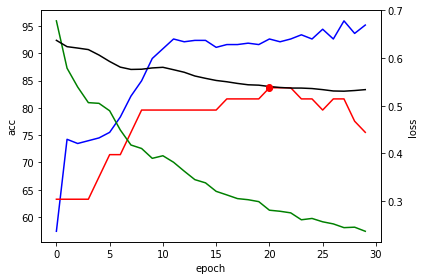

In [13]:
## 결과 그래프 그리기
print('Best model valid loss|acc|f1: %d - %.2f | %.2f | %.2f' %(best_idx, valid_loss[best_idx], valid_acc[best_idx], valid_f1[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.savefig(os.path.join(save_path, 'result.png'))
plt.show()

# For test

In [14]:
weights_path = os.path.join(save_path, 'best_model.pt')

In [15]:
## load model for test
def load_model_for_test(weights_path, num_classes=2):
    
    # load best model from weight
    # weights_path = 'output_crop/model_4_100.00_100.00.pt'


    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    ## load model
    from efficientnet_pytorch import EfficientNet
    model_name = 'efficientnet-b0'  # b5
#     num_classes = 2  # 장싱, 비정상
    freeze_extractor = True  # FC layer만 학습하고 efficientNet extractor 부분은 freeze하여 학습시간 단축, 89860 vs 4097408
    use_multi_gpu = True

    model_load = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)  # load weight
    model_load.load_state_dict(state_dict, strict=False)  # insert weight to model structure

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)            
    print('학습 parameters 개수 : %d'%(count_parameters(model_load)))

    # multi gpu(2개 이상)를 사용하는 경우
    if use_multi_gpu:
        num_gpu = torch.cuda.device_count()
        if (device.type=='cuda') and (num_gpu > 1):
            print('use multi gpu : %d' % (num_gpu))
            model_load = nn.DataParallel(model_load, device_ids=list(range(num_gpu)))

    model_load = model_load.to(device)


    # define optimizer, criterion
    criterion = nn.CrossEntropyLoss()  # 분류이므로 cross entrophy 사용    
    
    return model_load, criterion, device

model_load, criterion, device = load_model_for_test(weights_path, num_classes=num_classes)

Loaded pretrained weights for efficientnet-b0
학습 parameters 개수 : 4010110


test done : loss|acc|f1 : 0.608 | 81.82 | 77.08 


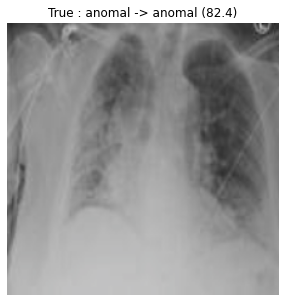

data_covid19/anomal/ae6c954c0039de4b5edee53865ffee43-e6c8-0.jpg


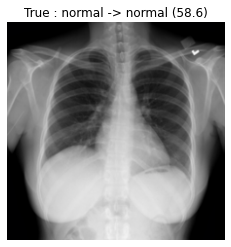

data_covid19/normal/00003190_018.png


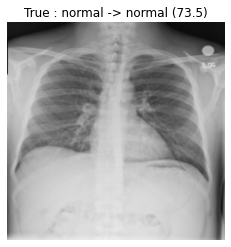

data_covid19/normal/00000206_000.png


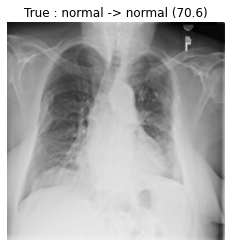

data_covid19/normal/00001501_008.png


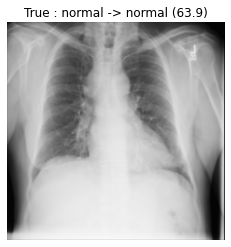

data_covid19/normal/00003129_004.png


In [16]:
# get_test_metric
def get_test_metric(model, phase = 'test', num_images=5, device='cuda', is_Test=False):
    ## 데이타 체크
    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated

    was_training = model.training
    model.eval()

    running_loss, running_corrects, num_cnt = 0.0, 0, 0
    pred_list, label_list, probability_list, image_list = [], [], [], []

    # 데이터 path 추적을 위해
    test_idices = datasets['test'].indices
    all_data_path = datasets['test'].dataset.samples
    file_path = [all_data_path[iii][0] for iii in test_idices]
    label_path = [all_data_path[iii][1] for iii in test_idices]

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[phase]):

            if is_Test:
                if idx > 2: break

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs_softmax = nn.Softmax(dim=1)(outputs)  # tensor([[0.0094, 0.9906]]
            probability, preds = torch.max(outputs_softmax, 1)

            loss = criterion(outputs_softmax, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

            pred_list  += preds.data.cpu().numpy().tolist()
            label_list += labels.data.cpu().numpy().tolist()
            probability_list += probability.cpu().numpy().tolist()
            image_list += inputs.cpu().data

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt
        test_f1   = float(f1_score(label_list, pred_list, average='macro'))  # micro    
        print('test done : loss|acc|f1 : %.3f | %.2f | %.2f ' % (test_loss, test_acc*100, test_f1*100))


    label_string = [str(tmp) for tmp in label_list]
    preds_string = [str(tmp) for tmp in pred_list]
    input_image = inputs.cpu().data

    plt.figure(figsize=(15, 5))
    for j in range(1, num_images+1):
        plt.axis('off')
        plt.title('%s : %s -> %s (%.1f)'%(
            'True' if class_names[label_string[j]]==class_names[preds_string[j]] else 'False!!!',
            class_names[label_string[j]], class_names[preds_string[j]],
            probability_list[j]*100
        ))
        imshow(image_list[j])
        print(file_path[j])         

    return label_list, pred_list


## TEST!
label_list, outputs_list = get_test_metric(model=model_load, num_images=5, device=device)

# GradCAM 분석

In [17]:
## efficient net
print('!!!!!! load done, efficient net!!')
# features_fn  = model_load.module.features_fn
# classifier_fn= model_load.module.classifier_fn
features_fn  = model_load.features_fn
classifier_fn= model_load.classifier_fn

!!!!!! load done, efficient net!!


In [18]:
def GradCAM(img, class_idx, features_fn, classifier_fn):

    feature = features_fn(img.cuda())  # A, [1, 1280, 7, 7]
    _, N, H, W = feature.size()  # 1280, 7, 7
    out = classifier_fn(feature)  # shape : [1, 7] - [-2.6593, -5.3088, -2.2299, -1.2445,  2.3712, -2.7554, 11.4827]
    class_score = out[0, class_idx]  # class_idxc=6이면 심상정일 때의 score, 11.4827

    # gradients via back-propagation
    # 특정 클래스(class_idx)의 gradient (dy/dA)
    # 최종단과 feature단의 미분값을 구한다
    grads = torch.autograd.grad(class_score, feature)  # grads = K.gradients(y_c, layer_output)[0]

    # a_k_c, Global average pooling
    weights = torch.mean(grads[0][0], axis=(1,2))  # (1280, 7, 7) -> (1280)

    ####################################################
    ## 1. torch 방법
    heatmap = torch.matmul(weights, feature.view(N, H*W))  # liniear combination : a_k_c * A__k, 1280 * (1280, 49)
    heatmap = heatmap.view(H, W).cpu().detach().numpy()  # (7, 7)
    ####################################################
    ## 2. 다른 방법 - https://github.com/jacobgil/pytorch-grad-cam/blob/master/gradcam.py
    # target = feature[0].cpu().data.numpy()
    # heatmap = np.zeros(target.shape[1:], dtype=np.float32)
    # for i, w in enumerate(weights):
    #     heatmap += w.cpu().data.numpy() * target[i, :, :]
    ####################################################
    grad_cam = np.maximum(heatmap, 0)  # ReLU, 0보다 큰값만 살린다
    # 0~1 사이로 정규화
    grad_cam -= grad_cam.min()
    grad_cam /= grad_cam.max()
    
    return grad_cam

In [19]:
# Opens image from disk, normalizes it and converts to tensor
read_image_to_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])

data_covid19/anomal
True: anomal -> anomal (55.52)


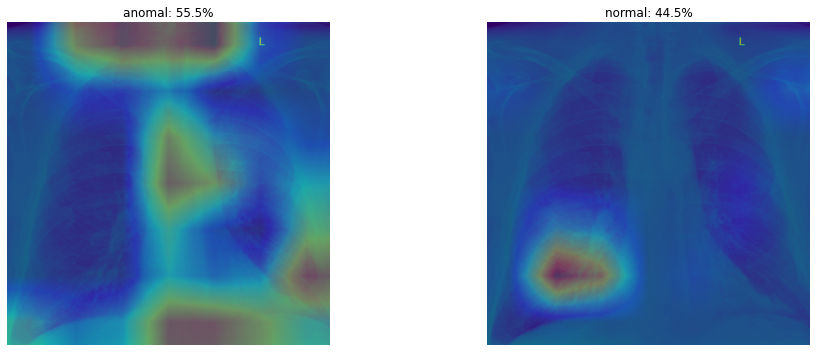

True: anomal -> anomal (69.41)


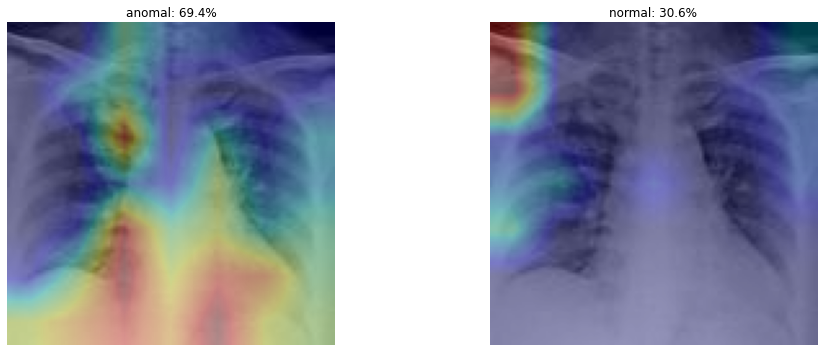

!!!Fail!!!: anomal -> normal (89.36)


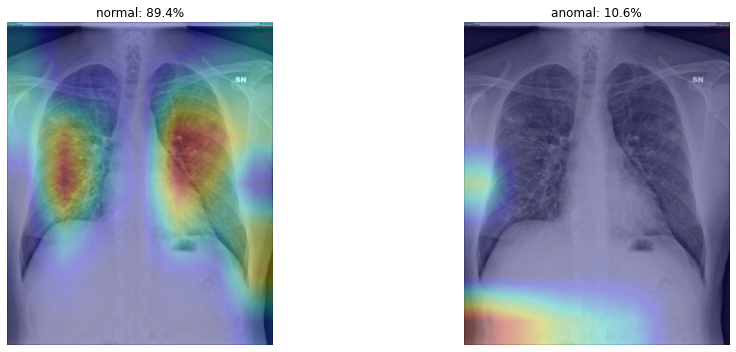

In [20]:
## Plot GradCAM
import glob
imshow_number = 3
top_k = 5

# for bouding box
from skimage.measure import regionprops, label
from matplotlib.patches import Rectangle
def extract_bboxes(canvas, threshold):
    labeled = label(canvas > threshold)
    bboxes = regionprops(labeled)
    rects = []
    for b in bboxes:
        ys, xs, ye, xe = b.bbox
        w = xe - xs
        h = ye - ys

        rect = Rectangle((xs, ys), w, h, 
                         linewidth=1.5, color='r', 
                         fill=None, alpha=0.5)
        rects.append(rect)
    return rects


def plot_gradcam(data_path, class_label=0, top_k=3, imshow_number=5, bbox=True):
#     class_label = 0  # 0: 이재명, ..
    if top_k > num_classes:
        top_k = num_classes

    folder_list = sorted([tmp for tmp in os.listdir(os.path.join(data_path)) if '.' not in tmp])
    folder_path = os.path.join(data_path, folder_list[class_label])  # 'data/data_president/1_이재명'

    print(folder_path)
    
    # img_path = 'data/data_president/1_이재명/naver_0383.jpg'
    
    # jpg, png 모두 가능하도록
    show_image_list = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png'))
    model_load.eval()  # 가장중요!! 이거 안하면 계속 모델 weight가 바뀐다ㅠ
    for img_path in  show_image_list[:imshow_number]:
        img_tensor = read_image_to_tensor(img_path)
        output = model_load(img_tensor.to(device))  # tensor([[-2.6664,  2.5967]])
        output_softmax = nn.Softmax(dim=1)(output)  # tensor([[0.0094, 0.9906]]
        class_probability, class_idx = torch.topk(output_softmax, top_k)  # top1: (tensor([[0.9944]]), tensor([[1]])), tok2라면 ([[0.9819, 0.0181]], [[1, 0]])
        # pp, cc = torch.topk(nn.Softmax(dim=1)(model_load(img_tensor.cuda())), 1)  # 3->1

        class_label_string = class_names['%s'%(class_label)]
        class_idx_string = class_names['%s'%(class_idx.cpu().numpy()[0][0])]
        class_probability_string = class_probability.cpu().tolist()[0][0]

        print('%s: %s -> %s (%.2f)'%(('True' if class_label==class_idx.cpu().numpy()[0][0] else '!!!Fail!!!'), class_label_string, class_idx_string, class_probability_string*100))

        # plot GradCAM
        plt.figure(figsize=(15, 5))
        for i, (p, c) in enumerate(zip(class_probability[0], class_idx[0])):
            plt.subplot(1, top_k, i+1)
            grad_cam = GradCAM(img_tensor, int(c), features_fn, classifier_fn)  # 7x7
            img = Image.open(img_path)
            grad_cam = Image.fromarray(grad_cam)
            grad_cam = grad_cam.resize(img.size, resample=Image.LINEAR)  # 7x7 -> 224x224
#             print(i, p, c, str(int(c.cpu())))
            plt.title('{}: {:.1f}%'.format(class_names[str(int(c.cpu()))], 100*float(p)))
            plt.axis('off')
            plt.imshow(img)
            plt.imshow(np.array(grad_cam), alpha=0.3, cmap='jet')
            if bbox:
                list_bbox = extract_bboxes(np.array(grad_cam), 0.5)  # get bbox, over 0.5 in gradcam value
                for bbox in list_bbox:
                    plt.gca().add_patch(bbox)  # plot bbox
        
        plt.tight_layout()  # subplot 간격 줄이기
        plt.savefig('tmp.jpg', bbox_inches='tight', pad_inches=0)    
        plt.show()
    return

plot_gradcam(data_path, class_label=0, top_k=top_k, imshow_number=imshow_number, bbox=bbox)

data_covid19/normal
True: normal -> normal (67.07)


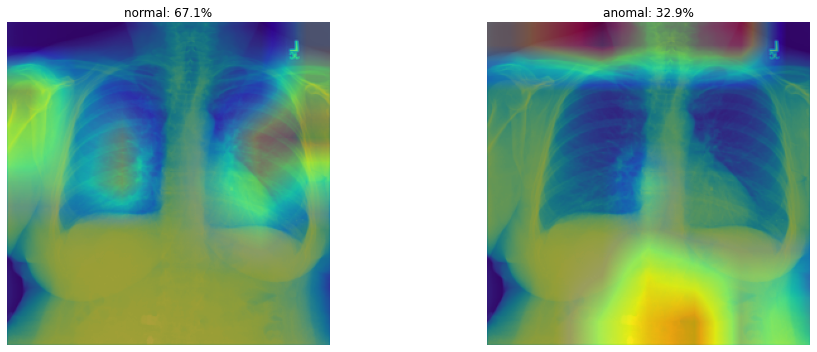

!!!Fail!!!: normal -> anomal (62.27)


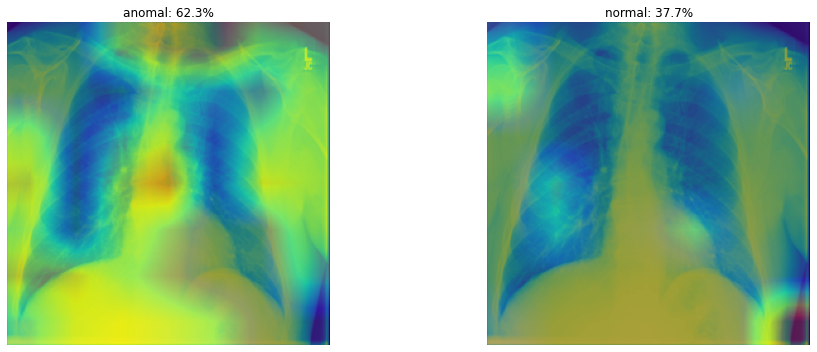

True: normal -> normal (67.75)


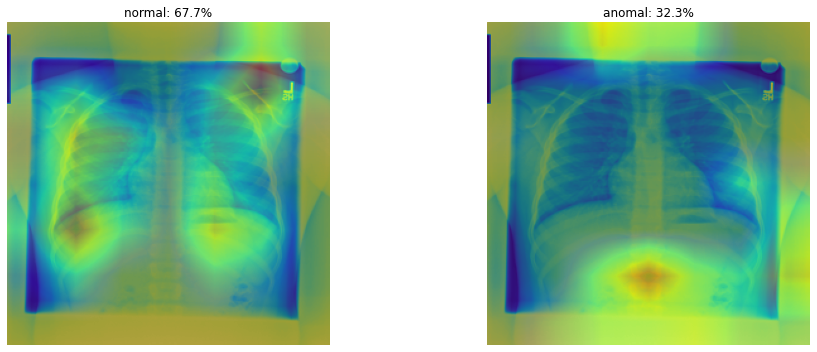

In [21]:
plot_gradcam(data_path, class_label=1, top_k=top_k, imshow_number=imshow_number, bbox=bbox)

# Adversarial Attack

1) FGSM(Fast Gradient Sign Method)

모델의 파라미터를 바꿔가면서 예측 비용이 가장 낮아지는 지점을 찾는다. FGSM에서는 모델은 이미 학습이 끝난 상태이므로 파라미터가 고정되고 데이터에 조작을 가한다. 그리고 예측 비용이 가장 높아지는 방향, 즉 모델이 최대한 오답을 내도록 이미지를 변형

- https://leedakyeong.tistory.com/entry/%EB%85%BC%EB%AC%B8-FGSM-%EB%A6%AC%EB%B7%B0-EXPLAINING-AND-HARNESSING-ADVERSARIAL-EXAMPLES
- https://rain-bow.tistory.com/entry/Adversarial-Attack
- https://github.com/Jeffkang-94/pytorch-adversarial-attack

In [22]:
weights_path = os.path.join(save_path, 'best_model.pt')

In [23]:
## load model for test
def load_model_for_test(weights_path, num_classes=2):
    
    # load best model from weight
    # weights_path = 'output_crop/model_4_100.00_100.00.pt'


    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    ## load model
    from efficientnet_pytorch import EfficientNet
    model_name = 'efficientnet-b0'  # b5
#     num_classes = 2  # 장싱, 비정상
    freeze_extractor = True  # FC layer만 학습하고 efficientNet extractor 부분은 freeze하여 학습시간 단축, 89860 vs 4097408
    use_multi_gpu = True

    model_load = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)  # load weight
    model_load.load_state_dict(state_dict, strict=False)  # insert weight to model structure

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)            
    print('학습 parameters 개수 : %d'%(count_parameters(model_load)))

    # multi gpu(2개 이상)를 사용하는 경우
    if use_multi_gpu:
        num_gpu = torch.cuda.device_count()
        if (device.type=='cuda') and (num_gpu > 1):
            print('use multi gpu : %d' % (num_gpu))
            model_load = nn.DataParallel(model_load, device_ids=list(range(num_gpu)))

    model_load = model_load.to(device)


    # define optimizer, criterion
    criterion = nn.CrossEntropyLoss()  # 분류이므로 cross entrophy 사용    
    
    return model_load, criterion, device

model_load, criterion, device = load_model_for_test(weights_path, num_classes=num_classes)

Loaded pretrained weights for efficientnet-b0
학습 parameters 개수 : 4010110


In [24]:
import torch.nn.functional as F
aa_model = model_load  # model 저장
aa_model.eval();

In [25]:
# 예시 그림 plot
phase = 'test'
img_idx = 0

with torch.no_grad():
    inputs, labels = next(iter(dataloaders['test']))        
        
img_tensor, label = inputs.to(device), labels.to(device)
img_batch = img_tensor[img_idx].unsqueeze(0)  # [1, 3, 224, 224]
# label_batch = label[0]  # tensor(0, device='cuda:0')
label_batch = label[img_idx:img_idx+1]  # tensor([0], device='cuda:0')

# 입력 이미지의 gradient를 구해야 하므로 requires_grad를 True로 설정한다.
img_batch.requires_grad = True

In [26]:
# 분류 결과를 얻는다.
logits = aa_model(img_batch)  # [16.2607, -5.2704, -4.4725, -3.5213, -2.5452, -2.0208,  1.8761]
probs = F.softmax(logits, dim=1)[0]  # [1.0000e+00, 4.4582e-10, 9.9018e-10, ..]


In [27]:
# 비용을 계산하고
# backpropagation을 실행한다.
cost_fn = nn.CrossEntropyLoss()
cost = cost_fn(logits, label_batch)  # tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
cost.backward()

In [28]:
# 비용에 대한 원본 이미지의 gradient를 구한다.
grad = img_batch.grad.detach()[0] # ▽xJ(θ,x,y), batch 차원을 없앤다. # [3, 224, 224]
signed_grad = torch.sign(grad)    # sign(▽xJ(θ,x,y)), 부호만 살린다. 양수는 1, 음수는 -1, # [3, 224, 224]
epsilon = 0.1                     # ϵ = epsilon
eta = epsilon * signed_grad       # η = ϵ*sign(▽xJ(θ,x,y), -0.1, +0.1 값을 갖는 행렬, [3, 224, 224]

In [29]:
# 원본 이미지에 perturbation을 가해 Adversarial Example을 만든다.
img_hat_batch = img_batch + eta # x_=x+η

In [30]:
img_batch[0][0][0][:8]

tensor([-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [31]:
eta[0][0][:8]

tensor([-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000],
       device='cuda:0')

In [32]:
img_hat_batch[0][0][0][:8]

tensor([-2.2179, -2.2179, -2.2179, -2.2179, -2.2179, -2.2179, -2.2179, -2.2179],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [33]:
## 데이타 체크 함수
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

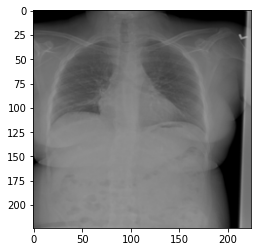

In [34]:
# 원본 이미지 체크
imshow(img_batch[0].detach().cpu())

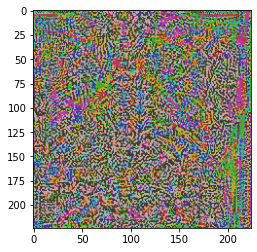

In [35]:
# adversarial attack 체크
imshow(signed_grad.cpu())

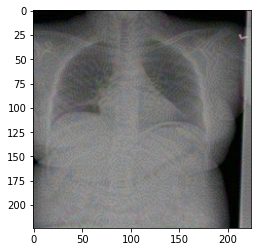

In [36]:
# 원본이미지 + adversarial attack 체크
imshow(img_hat_batch[0].cpu().data)

tensor([0.4638, 0.5362], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.5485, 0.4515], device='cuda:0', grad_fn=<SelectBackward0>)


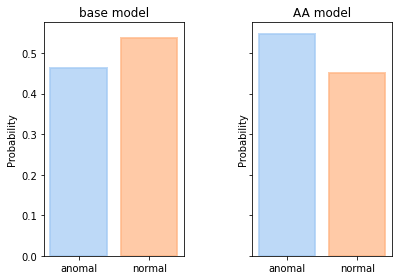

In [37]:
## 분류 결과 차이 비교
# 정상 분류 결과
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, sharey=True)
fig.subplots_adjust(wspace=50)
colors = sns.color_palette('pastel', len(list(class_names.values())))

logits = aa_model(img_batch)  # [16.2607, -5.2704, -4.4725, -3.5213, -2.5452, -2.0208,  1.8761]
probs = F.softmax(logits, dim=1)[0]  # [1.0000e+00, 4.4582e-10, 9.9018e-10, ..]
# plt.bar(['chu', 'hong', 'hwang', 'myung', 'yeon', 'park', 'sim'], list(probs.cpu().data.numpy()))
axs[0].bar(list(class_names.values()), list(probs.cpu().data.numpy()), color=colors, edgecolor=colors, alpha=0.7, linewidth=2)
axs[0].set_title('base model')
axs[0].set_ylabel('Probability')
print(probs)
# AA분류 결과
aa_logits = aa_model(img_hat_batch)  # [16.2607, -5.2704, -4.4725, -3.5213, -2.5452, -2.0208,  1.8761]
aa_probs = F.softmax(aa_logits, dim=1)[0]  # [1.0000e+00, 4.4582e-10, 9.9018e-10, ..]
axs[1].bar(list(class_names.values()), list(aa_probs.cpu().data.numpy()), color=colors, edgecolor=colors, alpha=0.7, linewidth=2)
axs[1].set_title('AA model')
axs[1].set_ylabel('Probability')
print(aa_probs)
plt.tight_layout()
plt.show()

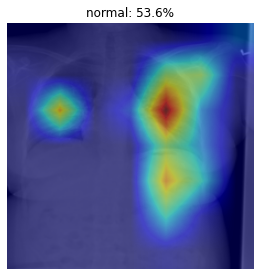

In [38]:
# Plot GradCAM on Original input
img_tensor = img_batch
pp, cc = torch.topk(nn.Softmax(dim=1)(aa_model(img_tensor)), 1)  # 3->1
plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    grad_cam = GradCAM(img_tensor, int(c), features_fn, classifier_fn)  # 7x7
#     img = Image.open(img_path)

    # tensor to img
    inp = img_tensor[0].cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    grad_cam = Image.fromarray(grad_cam)
    grad_cam = grad_cam.resize((224, 224), resample=Image.LINEAR)  # 7x7 -> 224x224

    plt.title('{}: {:.1f}%'.format(class_names[str(int(c.cpu()))], 100*float(p)))
    plt.axis('off')
    plt.imshow(np.array(grad_cam), alpha=0.5, cmap='jet')
plt.show()

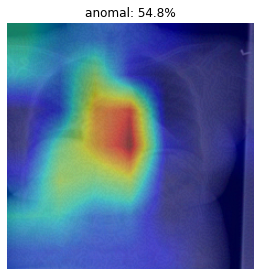

In [39]:
# Plot GradCAM on adversarial example input
img_tensor = img_hat_batch

pp, cc = torch.topk(nn.Softmax(dim=1)(aa_model(img_tensor)), 1)  # 3->1
plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    grad_cam = GradCAM(img_tensor, int(c), features_fn, classifier_fn)  # 7x7
#     img = Image.open(img_path)

    # tensor to img
    inp = img_tensor[0].cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    grad_cam = Image.fromarray(grad_cam)
    grad_cam = grad_cam.resize((224, 224), resample=Image.LINEAR)  # 7x7 -> 224x224

    plt.title('{}: {:.1f}%'.format(class_names[str(int(c.cpu()))], 100*float(p)))
    plt.axis('off')
    plt.imshow(np.array(grad_cam), alpha=0.5, cmap='jet')
plt.show()

# Various Adversarial Attaact

###### https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/demos/White%20Box%20Attack%20(ImageNet).ipynb

In [40]:
weights_path = os.path.join(save_path, 'best_model.pt')
batch_size = 50
number_show_image = 5

In [41]:
## load model for test
def load_model_for_test(weights_path, num_classes=2):
    
    # load best model from weight
    # weights_path = 'output_crop/model_4_100.00_100.00.pt'


    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    ## load model
    from efficientnet_pytorch import EfficientNet
    model_name = 'efficientnet-b0'  # b5
#     num_classes = 2  # 장싱, 비정상
    freeze_extractor = True  # FC layer만 학습하고 efficientNet extractor 부분은 freeze하여 학습시간 단축, 89860 vs 4097408
    use_multi_gpu = True

    model_load = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)  # load weight
    model_load.load_state_dict(state_dict, strict=False)  # insert weight to model structure

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)            
    print('학습 parameters 개수 : %d'%(count_parameters(model_load)))

    # multi gpu(2개 이상)를 사용하는 경우
    if use_multi_gpu:
        num_gpu = torch.cuda.device_count()
        if (device.type=='cuda') and (num_gpu > 1):
            print('use multi gpu : %d' % (num_gpu))
            model_load = nn.DataParallel(model_load, device_ids=list(range(num_gpu)))

    model_load = model_load.to(device)


    # define optimizer, criterion
    criterion = nn.CrossEntropyLoss()  # 분류이므로 cross entrophy 사용    
    
    return model_load, criterion, device

model_load, criterion, device = load_model_for_test(weights_path, num_classes=num_classes)

Loaded pretrained weights for efficientnet-b0
학습 parameters 개수 : 4010110


In [42]:
## load liabrary
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision.utils import make_grid
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import adversarial_attacks_pytorch.torchattacks
from adversarial_attacks_pytorch.demos.utils import imshow, imshow_both, image_folder_custom_label

In [43]:
## prepare data
# make dataset
from torchvision import transforms, datasets
from torch.utils.data import Subset, dataloader


# transform_function = transforms.Compose([transforms.Resize((224, 224)),  # 모델 입력사이즈로 resize
#                                          transforms.ToTensor(),
#                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#                                         ])
## AA는 입력이 0~1인 상태에서 공격하므로 normalize는 뒤에서 하자
transform_function_aa = transforms.Compose([transforms.Resize((224, 224)),
                                            transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
#                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                           ])

# class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
dataset_aa = datasets.ImageFolder(data_path,
                               transform_function_aa)

# make 8:1:1 idx & dataset
random_seed = 220103
random.seed(random_seed)
torch.manual_seed(random_seed)
random_idx = list(range(0, len(dataset_aa)))
random.shuffle(random_idx)
print('total data num : %d'%len(random_idx))
print('random check : %s'%random_idx[:5])

proportion = [8, 1, 1]  ## !! 이 부분을 6, 2, 2로 바꾸면 train/valid/test 비율 조정 가능
proportion_data = [tmp*int(len(random_idx)/10) for tmp in proportion]
# assert sum(proportion_data) == len(random_idx)  # 반올림해서 총합은 틀려진다

train_idx = random_idx[:proportion_data[0]]
valid_idx = random_idx[proportion_data[0] : proportion_data[0]+proportion_data[1]]
test_idx  = random_idx[proportion_data[0]+proportion_data[1] :]

print('data proportion(train:valid:test) = %s : %s : %s'%(len(train_idx), len(valid_idx), len(test_idx)))

datasets_aa = {}
datasets_aa['train'] = Subset(dataset_aa, train_idx)
datasets_aa['valid'] = Subset(dataset_aa, valid_idx)
datasets_aa['test']  = Subset(dataset_aa, test_idx)


total data num : 496
random check : [119, 236, 359, 311, 259]
data proportion(train:valid:test) = 392 : 49 : 55


In [44]:
## data loader 선언
dataloaders_aa, batch_num_aa = {}, {}
dataloaders_aa['train'] = torch.utils.data.DataLoader(datasets_aa['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders_aa['valid'] = torch.utils.data.DataLoader(datasets_aa['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders_aa['test']  = torch.utils.data.DataLoader(datasets_aa['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num_aa['train'], batch_num_aa['valid'], batch_num_aa['test'] = len(dataloaders_aa['train']), len(dataloaders_aa['valid']), len(dataloaders_aa['test'])
print('batch_size : %d,  number of batch(tvt) : %d / %d / %d' % (batch_size, batch_num_aa['train'], batch_num_aa['valid'], batch_num_aa['test']))

batch_size : 50,  number of batch(tvt) : 8 / 1 / 2


True Image & True Label


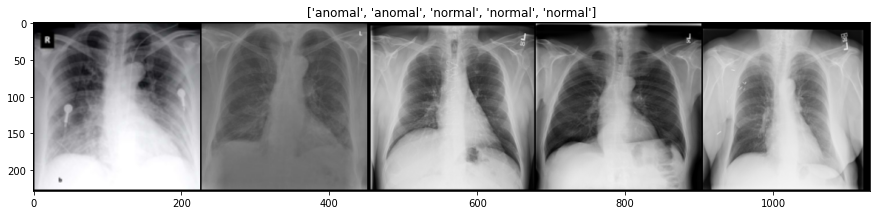

In [45]:
## data check
images, labels = iter(dataloaders_aa['test']).next()

print("True Image & True Label")
imshow(make_grid(images[:number_show_image], normalize=True), [list(class_names.values())[i] for i in labels[:number_show_image]])  # n개만 그리자

In [46]:
## prepare model 
# transform에서 normalize하던걸 떼어내서 model의 앞에 부친다. AA는 입력이 0~1이어야 하므로
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# Adding a normalization layer for Resnet18.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(norm_layer, 
                      model_load  # 학습한 EfficientNet
                     ).to(device)

model = model.eval()

In [47]:
## load attacker
# from adversarial_attacks_pytorch.torchattacks import *
from adversarial_attacks_pytorch.torchattacks.attacks.fgsm import FGSM
from adversarial_attacks_pytorch.torchattacks.attacks.pgd import PGD

atks = [
    FGSM(model, eps=8/255),
#     BIM(model, eps=8/255, alpha=2/255, steps=100),
#     RFGSM(model, eps=8/255, alpha=2/255, steps=100),
#     CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
#     PGDL2(model, eps=1, alpha=0.2, steps=100),
#     EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
#     FFGSM(model, eps=8/255, alpha=10/255),
#     TPGD(model, eps=8/255, alpha=2/255, steps=100),
#     MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
#     VANILA(model),
#     GN(model, std=0.1),
#     APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
#     APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
#     APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
#     FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
#     FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
#     Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
#     AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
#     OnePixel(model, pixels=5, inf_batch=50),
#     DeepFool(model, steps=100),
#     DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)


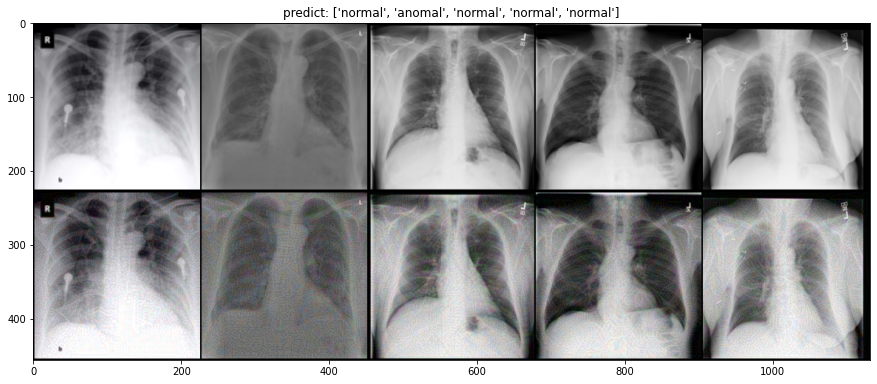

Total elapsed time (sec): 0.68
Robust accuracy: 36.00 %
----------------------------------------------------------------------
PGD(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.008888888888888889, steps=100, random_start=True, attack_mode=default, return_type=float)


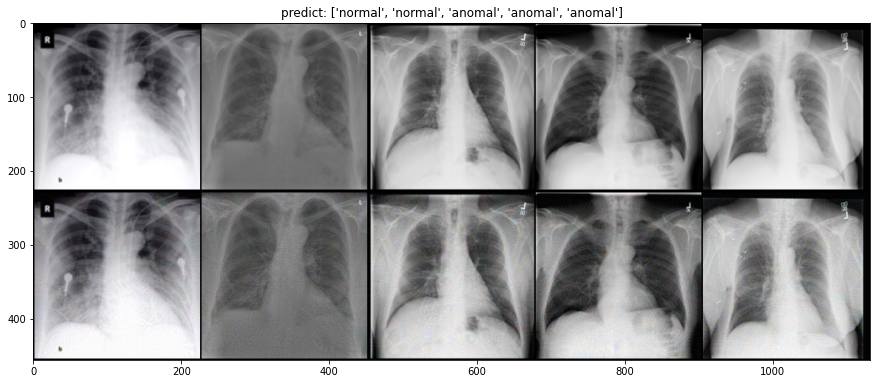

Total elapsed time (sec): 7.94
Robust accuracy: 0.00 %


In [48]:
## attack!
print("Adversarial Image & Predicted Label")

for atk in atks:
    
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    for idx, (images, labels) in enumerate(dataloaders_aa['test']):
        
        start = time.time()
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = model(adv_images)

        _, predict = torch.max(outputs.data, 1)

        total += len(labels)
        correct += (predict == labels).sum()

#         imshow(torchvision.utils.make_grid(adv_images.cpu().data[:number_show_image], normalize=True), [list(class_names.values())[i] for i in predict[:number_show_image]])  # n개만 그리자
        imshow_both(make_grid(images.cpu().data[:number_show_image],normalize=True),
                    make_grid(adv_images.cpu().data[:number_show_image],normalize=True),
                    [list(class_names.values())[i] for i in predict[:number_show_image]])  # n개만 그리자
        
        if idx == 0 : break  # 첫 배치만 돌리자
        
    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

# Done